In [21]:
import json
from data_preparation import prepro_data_gp, prepro_data_pce, prepro_data_kl, preprocess_field_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

import matplotlib.pyplot as plt
from metamodels import GpMetamodel, VPCEMetamodel, KarhunenLoeveMetamodel

import pickle

BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
_ = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [_['chemistry']['cleaning'][i]['time']/24 for i in range(len(_['chemistry']['cleaning']))]

HOURLY_GRID = np.linspace(0, 420481, 420481).astype(int)

# GP metamodel build

In [10]:
TREND = 'Quad'
COV = 'AbsExp'

In [11]:
### DATA ###
lhs_hl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_hl.npy', allow_pickle=True)
lhs_cl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_cl.npy', allow_pickle=True)

mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_cl.npy', allow_pickle=True)


## For the LHS DoE

In [16]:
n_max = lhs_hl.shape[0]
n_samp = 1000
dimension = 2

In [123]:
X, y, scaler = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=True)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [125]:
gp = GpMetamodel(trend=TREND, kernel=COV, dimension=dimension)

In [126]:
gp.fit(X_train, y_train)

In [127]:
y_pred = gp.predict(X_test)
print(f'R2 = {r2_score(y_test, y_pred)}')

R2 = 0.9915884013802161


In [128]:
X, y = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=False)
_, X_test, _, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

real_test = []
for l in range(X_test.shape[0]):
    rand_test = []
    for q in range(0, len(SIMULATION_TIME)):
         rand_test.append(list(X_test[l, :dimension-1]) + [SIMULATION_TIME[q]*24])
    real_test.append(rand_test)
real_test = np.array(real_test)

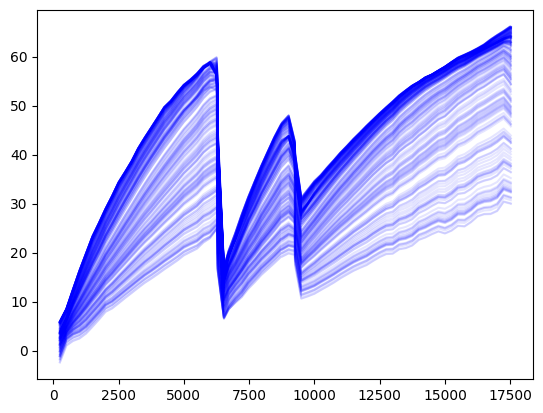

In [129]:
for l in range(X_test.shape[0]):
    scaled_test = scaler.transform(real_test[l,:,:])
    pred_traj = gp.predict(scaled_test)
    plt.plot(SIMULATION_TIME, pred_traj, color='blue', alpha=0.1)

In [130]:
with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_lhs.pkl', 'wb') as f:
    pickle.dump(gp.gp.getResult().getMetaModel(), f) # :D gp.gp

## For the MC DoE

In [131]:
X, y, scaler = prepro_data_gp(mc_hl, mc_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=True)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

In [133]:
gp = GpMetamodel(trend=TREND, kernel=COV, dimension=dimension)

In [134]:
gp.fit(X_train, y_train)

WRN - (previous message repeated 1 time)
WRN - Warning! For coherency we set scale upper bounds = [6.86092,6.80553]


In [135]:
y_pred = gp.predict(X_test)
print(f'R2 = {r2_score(y_test, y_pred)}')

R2 = 0.9987270601494765


In [136]:
X, y = prepro_data_gp(lhs_hl, lhs_cl, SIMULATION_TIME, n_max, n_samp, dimension, scale=False)
_, X_test, _, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

real_test = []
for l in range(X_test.shape[0]):
    rand_test = []
    for q in range(0, len(SIMULATION_TIME)):
         rand_test.append(list(X_test[l, :dimension-1]) + [SIMULATION_TIME[q]*24])
    real_test.append(rand_test)
real_test = np.array(real_test)

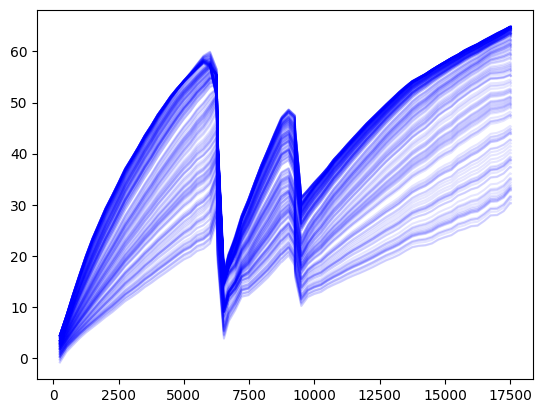

In [137]:
for l in range(X_test.shape[0]):
    scaled_test = scaler.transform(real_test[l,:,:])
    pred_traj = gp.predict(scaled_test)
    plt.plot(SIMULATION_TIME, pred_traj, color='blue', alpha=0.1)

In [138]:
with open(BASE_DIRECTORY + f'metamodels/GP/gp_{TREND}_{COV}_mc.pkl', 'wb') as f:
    pickle.dump(gp.gp.getResult().getMetaModel(), f) # :D gp.gp

# PCE metamodel

In [12]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates, 
                                           with_time_division=False)

## For the LHS DoE

In [23]:
X, y = prepro_data_pce(lhs_hl, lhs_cl, n_max, n_samp, dimension)

0 nan trajectories in output sample


In [24]:
y_interpolated = np.asarray([np.interp(HOURLY_GRID, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)

In [29]:
PCE = VPCEMetamodel(degree=3, q_norm=0.7)

In [30]:
PCE.fit(X_train, y_train, )

TypeError: VPCEMetamodel.fit() missing 2 required positional arguments: 'marginals' and 'distribution'